In [1]:
import couchdb
import random
import pandas as pd
import numpy as np
from scipy.special import softmax

In [2]:
user = "admin"
password = "admin"
couchserver = couchdb.Server("http://%s:%s@172.26.134.187:5984/" % (user, password))

In [3]:
db = couchserver['twitter']
rows = db.view('_design/Data/_view/Sentiment')

In [4]:
tweets = []

for row in rows:
    try:
        sentiment = row['value']['sentiment'][0]
        confidence = row['value']['sentiment'][1]
        if (float(confidence) > 0.8) and (sentiment == 'Positive' or sentiment == 'Negative'):
        #if sentiment == 'Positive':
            #tweets.append((row['value']['tweet'], row['value']['geo'][0], row['value']['geo'][1], row['value']['sentiment'][0], row['value']['sentiment'][1]))
            tweets.append((row['value']['tweet'], row['value']['sentiment'][0]))
    except:
        pass

In [5]:
tweets = pd.DataFrame(tweets)
tweets

,0,1
0,Happy 6th Birthday to this cheeky girl! #cat #...,Positive
1,Colourful things. Things of sea and air. I nee...,Positive
2,Finally home,Positive
3,Would always think fresh grilled cheese wpild ...,Positive
4,"@toastling cool friend, let's try to find a da...",Positive
...,...,...
70162,@smurf_lola12 glad you are still loving the mo...,Positive
70163,“@girlposts: I NEED TO SEE THIS MOVIE https://...,Negative
70164,Massages are the best 👌,Positive
70165,This was a brilliant show on Sunday @shadowele...,Positive


In [6]:
numTweets = 10000

In [7]:
data = pd.DataFrame(tweets).rename({0: "tweet", 1: "sentiment"}, axis='columns')#[:numTweets]

In [8]:
dfSentiment = data.copy(deep=True)
dfSentiment

,tweet,sentiment
0,Happy 6th Birthday to this cheeky girl! #cat #...,Positive
1,Colourful things. Things of sea and air. I nee...,Positive
2,Finally home,Positive
3,Would always think fresh grilled cheese wpild ...,Positive
4,"@toastling cool friend, let's try to find a da...",Positive
...,...,...
70162,@smurf_lola12 glad you are still loving the mo...,Positive
70163,“@girlposts: I NEED TO SEE THIS MOVIE https://...,Negative
70164,Massages are the best 👌,Positive
70165,This was a brilliant show on Sunday @shadowele...,Positive


In [9]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

# remove hashtags
def hashtags(text):
  hash = re.findall(r"#(\w+)", text)
  return hash

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/m.rossi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO
# translate emoji
def emoji(text):
  for emot in UNICODE_EMOJI:
    if text == None:
      text = text
    else:
      text = text.replace(emot, "_".join(UNICODE_EMOJI[emot].replace(",", "").replace(":", "").split()))
    return text

In [11]:
# remove retweet username and tweeted at @username
def remove_users(tweet):
  '''Takes a string and removes retweet and @user information'''
  tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) 
  # remove tweeted at
  return tweet

In [12]:
# remove links
def remove_links(tweet):
  '''Takes a string and removes web links from it'''
  tweet = re.sub(r'http\S+', '', tweet) # remove http links
  tweet = re.sub(r'bit.ly/\S+', '', tweet) # remove bitly links
  tweet = tweet.strip('[link]') # remove [links]
  return tweet
def clean_html(text):
  html = re.compile('<.*?>')#regex
  return html.sub(r'',text)

In [13]:
# remove non ascii character
def non_ascii(s):
  return "".join(i for i in s if ord(i)<128)

def lower(text):
  return text.lower()

In [14]:
# remove email address
def email_address(text):
  email = re.compile(r'[\w\.-]+@[\w\.-]+')
  return email.sub(r'',text)

def punct(text):
  token=RegexpTokenizer(r'\w+')#regex
  text = token.tokenize(text)
  text= " ".join(text)
  return text 

In [15]:
# remove stopwords
def removeStopWords(str):
#select english stopwords
  cachedStopWords = set(stopwords.words("english"))
#add custom words
  cachedStopWords.update(('and','I','A','http','And','So','arnt','This','When','It','many','Many','so','cant','Yes','yes','No','no','These','these','mailto','regards','ayanna','like','email'))
#remove stop words
  new_str = ' '.join([word for word in str.split() if word not in cachedStopWords]) 
  return new_str

In [16]:
# special characters removal
def remove_(tweet):
  tweet = re.sub('([_]+)', "", tweet)
  return tweet

In [17]:
#apply all the functions above
#dfSentiment['hashtag'] = dfSentiment.tweet.apply(func = hashtags)
dfSentiment['new_tweet'] = dfSentiment.tweet.apply(func = emoji)
dfSentiment['new_tweet'] = dfSentiment.new_tweet.apply(func = remove_users)
dfSentiment['new_tweet'] = dfSentiment.new_tweet.apply(func = clean_html)
dfSentiment['new_tweet'] = dfSentiment.new_tweet.apply(func = remove_links)
dfSentiment['new_tweet'] = dfSentiment.new_tweet.apply(func = non_ascii)
dfSentiment['new_tweet'] = dfSentiment.new_tweet.apply(func = lower)
dfSentiment['new_tweet'] = dfSentiment.new_tweet.apply(func = email_address)
dfSentiment['new_tweet'] = dfSentiment.new_tweet.apply(func = removeStopWords)
dfSentiment['new_tweet'] = dfSentiment.new_tweet.apply(func = clean_html)
dfSentiment['new_tweet'] = dfSentiment.new_tweet.apply(func = punct)
dfSentiment['new_tweet'] = dfSentiment.new_tweet.apply(func = remove_)

In [18]:
dfSentiment

,tweet,sentiment,new_tweet
0,Happy 6th Birthday to this cheeky girl! #cat #...,Positive,happy 6th birthday cheeky girl cat maxxie goos...
1,Colourful things. Things of sea and air. I nee...,Positive,colourful things things sea air needed splash ...
2,Finally home,Positive,finally home
3,Would always think fresh grilled cheese wpild ...,Positive,would always think fresh grilled cheese wpild ...
4,"@toastling cool friend, let's try to find a da...",Positive,cool friend let s try find day hang next time ...
...,...,...,...
70162,@smurf_lola12 glad you are still loving the mo...,Positive,glad still loving movie
70163,“@girlposts: I NEED TO SEE THIS MOVIE https://...,Negative,need see movie watching trailer makes cry
70164,Massages are the best 👌,Positive,massages best
70165,This was a brilliant show on Sunday @shadowele...,Positive,brilliant show sunday alexcameron indeed took ...


### Topic Modelling - Positive Tweets

In [21]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

In [19]:
dfPositive = dfSentiment.loc[dfSentiment['sentiment'] == 'Positive']
dfPositive

,tweet,sentiment,new_tweet
0,Happy 6th Birthday to this cheeky girl! #cat #...,Positive,happy 6th birthday cheeky girl cat maxxie goos...
1,Colourful things. Things of sea and air. I nee...,Positive,colourful things things sea air needed splash ...
2,Finally home,Positive,finally home
3,Would always think fresh grilled cheese wpild ...,Positive,would always think fresh grilled cheese wpild ...
4,"@toastling cool friend, let's try to find a da...",Positive,cool friend let s try find day hang next time ...
...,...,...,...
70160,Man I'm obsessed with them http://t.co/r0cacrWKN6,Positive,man i m obsessed
70161,Looking forward to @ChangeDayAus celebrations ...,Positive,looking forward celebrations tomorrow
70162,@smurf_lola12 glad you are still loving the mo...,Positive,glad still loving movie
70164,Massages are the best 👌,Positive,massages best


In [22]:
# start with 10k tweets only
embeddingsP = model.encode(list(dfPositive["new_tweet"]), show_progress_bar=True)

Batches:   0%|          | 0/1566 [00:00<?, ?it/s]

In [24]:
pd.to_pickle(embeddingsP, "./embeddingsP.pkl")
#embeddingsP = pd.read_pickle("./embeddingsP.pkl")

In [25]:
import umap
umap_embeddingsP = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddingsP)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [26]:
import hdbscan
clusterP = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddingsP)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

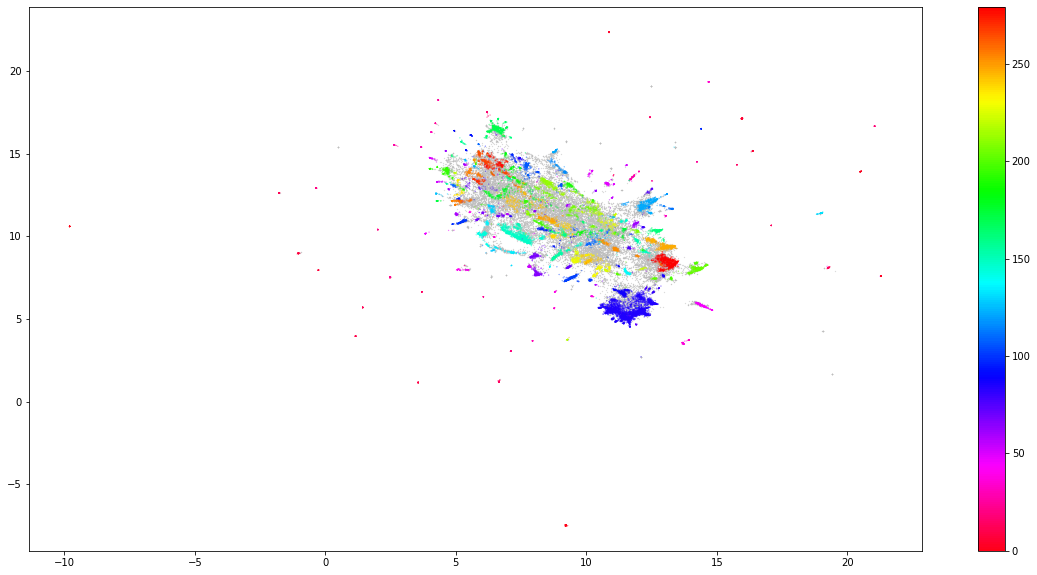

In [27]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddingsP)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = clusterP.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [28]:
d = list(dfPositive["new_tweet"])

In [30]:
docs_df = pd.DataFrame(d, columns=["Doc"])
docs_df['Topic'] = clusterP.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

In [34]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

/Users/m.rossi/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
0,-1,28517
85,84,3323
149,148,1086
280,279,737
204,203,535
123,122,464
172,171,421
248,247,376
103,102,372
46,45,311


In [49]:
top_n_wordsP = top_n_words
topic_sizesP = topic_sizes
topic_sizesP.head(10)

,Topic,Size
0,-1,28517
85,84,3323
149,148,1086
280,279,737
204,203,535
123,122,464
172,171,421
248,247,376
103,102,372
46,45,311


In [46]:
top_n_wordsP[84]

[('coffee', 0.06962234678377768),
 ('food', 0.06865970131693673),
 ('lunch', 0.04487393458796638),
 ('dinner', 0.04376645942860463),
 ('delicious', 0.043525351527798),
 ('melbourne', 0.04204718049944975),
 ('good', 0.03490952236452656),
 ('amp', 0.033678116390185614),
 ('chocolate', 0.031146190858427385),
 ('great', 0.030644009746157934),
 ('yum', 0.029913153664600005),
 ('best', 0.02924466972601787),
 ('yummy', 0.02871423747440248),
 ('breakfast', 0.02755485979349196),
 ('love', 0.026538360531761025),
 ('amazing', 0.02607992635021918),
 ('cake', 0.0254414173535087),
 ('day', 0.024400038990931478),
 ('chicken', 0.024345649723842937),
 ('cafe', 0.02387688290723022)]

### Topic Modelling - Negative Tweets

In [80]:
dfNegative = dfSentiment.loc[dfSentiment['sentiment'] == 'Negative']
dfNegative.head(20)

,tweet,sentiment,new_tweet
6,@yarratrams 109 followed by 12 city bound thro...,Negative,109 followed 12 city bound st vinc seriously t...
9,@janecat60 @leftocentre @PatsKarvelas Waste of...,Negative,waste everyone s time money
14,Compensation for #economicrefugees WTF What ab...,Negative,compensation economicrefugees wtf injuredworke...
16,@chrismurphys it's heartbreaking.,Negative,heartbreaking
20,Holy crap i dreamed about my death.......,Negative,holy crap dreamed death
28,"if I didn't have social media, my music, wifi ...",Negative,f social media music wifi youtube would die
36,"Cry me a river. Suspend my account, think I ca...",Negative,cry river suspend account think care lol screw...
41,"@jakepaul32 oh if it isn't little Jake Paul, K...",Negative,oh little jake paul kilsyths answer stament no...
47,@minxybinks pls continue to lobby as the chang...,Negative,pls continue lobby changes insane amp amp made...
49,Hey @simongterry - make you feel weird? http:/...,Negative,hey make feel weird
